In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.experimental.list_logical_devices("GPU")
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


## Fingerprint-based reactivity prediction model

This model takes as input the structural fingerprint for each of three reactants and a vector representing the reagents present. To indicate when one reactant is absent (_i.e._ a binary reaction), the model also takes a _presence_ bit vector, which is zero for any component that is missing in the reaction.

In [3]:
import itertools
import random
from math import factorial
from os import path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt

import fast_jtnn
import tensorflow as tf
import tensorflow.keras as tfk
from fast_jtnn.fp_calculator import FingerprintCalculator
from rdkit import Chem
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

sns.set(
    context="talk",
    style="ticks",
    font="Arial",
    font_scale=1.0,
    rc={"svg.fonttype": "none", "lines.linewidth": 1.5, "figure.autolayout": True},
)

In [4]:
JTNN_HOME = path.dirname(fast_jtnn.__path__[0])
JTNN_MODEL_PATH = path.join(JTNN_HOME, "data", "models", "model.iter-20000")
JTNN_MOLS = path.join(JTNN_HOME, "data", "full_train.txt")
JTNN_VOCAB_PATH = path.join(JTNN_HOME, "data", "vocab_full.txt")

In [5]:
chemical_spaces = {
    "simple": {
        "reactants_dict": {
            "phenyl_isocyanate": "O=C=N/c1ccccc1",
            "benzylamine": "c1ccc(cc1)CN",
            "cyclopentanone": "C1CCC(=O)C1",
            "cinnamaldehyde": "c1ccc(cc1)C=CC=O",
            "sorbic_alcohol": "CC=CC=CCO",
            "maleic_anhydride": "C1=CC(=O)OC1=O",
        },
        "reagents_dict": {"base": "C1CC2=NCCCN2C1",},
        "data": pd.read_csv("vector_space_simple.csv", index_col=None),
    },
    "photo": {
        "reactants_dict": {
            "bromoacetonitrile": "C(C#N)Br",
            "bromomalonate": "CCOC(=O)C(C(=O)OCC)Br",
            "diethyl_thiobarbituric_acid": "CCN1C(=O)CC(=O)N(C1=S)CC",
            "dimethyl_nitrosoaniline": "CN(C)c1ccc(cc1)N=O",
            "dimethylisoxazole": "CC1=CC(=NO1)C",
            "ethyl_vinyl_ether": "CCOC=C",
            "glycidyl_propargyl_ether": "C#CCOCC1CO1",
            "hexadienal": "CC=CC=CC=O",
            "indole": "C1=CC=C2C(=C1)C=CN2",
            "phenylboronic_acid": "B(C1=CC=CC=C1)(O)O",
            "phenylhydrazine": "C1=CC=C(C=C1)NN",
            "phenylurazole": "C1=CC=C(C=C1)N2C(=O)NNC2=O",
            "thiadiazole": "C1=NN=CS1",
            "tosyl_isocyanide": "CC1=CC=C(C=C1)S(=O)(=O)C[N+]#[C-]",
            "vinyl_pyrrolidinone": "C=CN1CCCC1=O",
        },
        "reagents_dict": {
            "base": "CN(C)C1=CC=NC=C1",
            "acid": "C(F)(F)(F)S(=O)(=O)[O-].C(F)(F)(F)S(=O)(=O)[O-].C(F)(F)(F)S(=O)(=O)[O-].[Sc+3]",
            "pyrylium": "F[B-](F)(F)F.c1ccc(cc1)-c2cc([o+]c(c2)-c3ccccc3)-c4ccccc4",
            "rose_bengal": "C1=C2C(=C3C=C(C(=O)C(=C3OC2=C(C(=C1I)O)I)I)I)C4=C(C(=C(C(=C4Cl)Cl)Cl)Cl)C(=O)O",
            "rubypy": "C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1.O.O.O.O.O.O.[Cl-].[Cl-].[Ru+2]",
        },
        "data": pd.read_csv("vector_space.csv", index_col=None),
    },
}

### Choice of chemical space

In [6]:
active_space = "photo"
chemical_space = chemical_spaces[active_space]
locals().update(chemical_space)

In [7]:
fp_calculator = FingerprintCalculator(
    model_path=JTNN_MODEL_PATH, vocab_path=JTNN_VOCAB_PATH
)

/home/group/mambaforge/envs/Rx1st/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
reactant_smiles = []
reactant_names = []

for name, smiles in reactants_dict.items():
    reactant_names.append(name)
    mol = Chem.MolFromSmiles(smiles)
    Chem.SanitizeMol(mol)
    reactant_smiles.append(Chem.MolToSmiles(mol))

In [9]:
reagent_smiles = []
reagent_names = []

for name, smiles in reagents_dict.items():
    reagent_names.append(name)
    mol = Chem.MolFromSmiles(smiles)
    Chem.SanitizeMol(mol)
    reagent_smiles.append(Chem.MolToSmiles(mol))

In [10]:
reactant_fps = fp_calculator(reactant_smiles)
reactant_fps.shape

100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


(15, 56)

In [11]:
data

,bromoacetonitrile,bromomalonate,diethyl_thiobarbituric_acid,dimethyl_nitrosoaniline,dimethylisoxazole,ethyl_vinyl_ether,glycidyl_propargyl_ether,hexadienal,indole,phenylboronic_acid,...,phenylurazole,thiadiazole,tosyl_isocyanide,vinyl_pyrrolidinone,base,acid,pyrylium,rose_bengal,rubypy,prediction
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.691278
1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0.165638
2,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0.693691
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.013263
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.699631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.802568
1014,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.593064
1015,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.474527
1016,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.588960


# Load dataset and associated fingerprints

In [12]:
reactant_mat = data[reactant_names].to_numpy(dtype=bool)
present_mat = np.sort(data[reactant_names].to_numpy(dtype="float32"))[:, :-4:-1]
reagent_mat = data[reagent_names].to_numpy(dtype="float32")
predictions = data.prediction.to_numpy(dtype="float32")

### Add reactivity class weights to balance the data

In [13]:
n_cats = 4
counts, edges = np.histogram(predictions, bins=n_cats)
weights = 1 / counts * len(predictions) / n_cats
bins = np.digitize(predictions, edges) - 1
bins = np.minimum(bins, n_cats - 1)

sample_weights = weights[bins]

In [14]:
reaction_fps = np.zeros(
    (reactant_mat.shape[0], 3, reactant_fps.shape[1]), dtype="float32"
)

for i, slice in enumerate(reactant_mat):
    reaction_fps[i, : sum(slice)] = reactant_fps[slice]

reaction_fps.shape

(1018, 3, 56)

In [15]:
(
    reactant_mat_train,
    reactant_mat_test,
    reactant_train,
    reactant_test,
    present_train,
    present_test,
    reagent_train,
    reagent_test,
    pred_train,
    pred_test,
    weights_train,
    weights_test,
) = train_test_split(
    reactant_mat,
    reaction_fps,
    present_mat,
    reagent_mat,
    predictions,
    sample_weights,
    test_size=0.1,
    random_state=2018,
)

# Model

## Normalization layer

Shift/scale molecular fingerprints to have a unit normal distribution around 0.

In [16]:
with open(JTNN_MOLS, "r") as f:
    smiles = [l.strip() for l in f]

fps = fp_calculator(smiles[:5000])

  4%|▍         | 1/25 [00:02<00:51,  2.16s/it]RDKit WARNING: [11:20:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:20:48] WARNING: not removing hydrogen atom without neighbors
 80%|████████  | 20/25 [00:41<00:09,  1.98s/it]RDKit WARNING: [11:21:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:21:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:21:27] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:21:27] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


In [17]:
normalizer = tfk.layers.experimental.preprocessing.Normalization()
normalizer.adapt(fps)

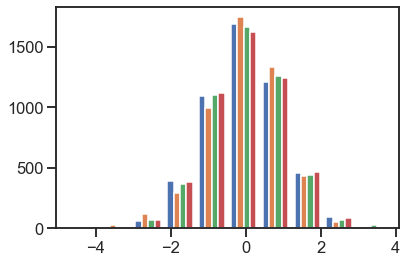

In [18]:
plt.hist(normalizer(fps).numpy()[:, 1:5]);

## Model definition

In [19]:
def nn_model(
    dropout0=0.3,
    dropout1=0.2,
    normalizer=normalizer,
    fp_length=56,
    n_reagents=reagent_mat.shape[-1],
):
    fp_inputs = [tfk.Input(shape=(fp_length)) for _ in range(3)]
    present_inputs = [tfk.Input(shape=(1,)) for _ in range(3)]
    rx_input = tfk.Input(shape=(n_reagents,))

    fp_processing = tfk.Sequential(
        [
            normalizer,
            tfk.layers.GaussianNoise(stddev=0.02),
            tfk.layers.Dropout(dropout0),
            tfk.layers.Dense(32),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dropout(dropout0),
            tfk.layers.Dense(16),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dropout(dropout1),
        ]
    )
    rx = tfk.layers.Dense(3, activation="relu")(rx_input)

    result = tfk.layers.Concatenate()(
        [*[fp_processing(fp_inputs[i]) for i in range(3)], *present_inputs, rx,]
    )

    rest = tfk.Sequential(
        [
            tfk.layers.Dense(24),
            tfk.layers.BatchNormalization(),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dense(16),
            tfk.layers.BatchNormalization(),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dense(8),
            tfk.layers.BatchNormalization(),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dense(4),
            tfk.layers.LeakyReLU(),
            tfk.layers.Dense(1, activation="sigmoid"),
        ]
    )

    result = rest(result)

    model = tfk.Model(inputs=[*fp_inputs, *present_inputs, rx_input,], outputs=result)

    return tfk.Model(
        inputs=[*fp_inputs, *present_inputs, rx_input],
        outputs=[
            model([*perm_fps, *perm_present, rx_input])
            for perm_fps, perm_present in zip(
                itertools.permutations(fp_inputs, 3),
                itertools.permutations(present_inputs, 3),
            )
        ],
    )

In [20]:
mdl = nn_model()

mdl.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = mdl.fit(
    x=[
        *reactant_train.transpose(1, 0, 2),
        *present_train.transpose(1, 0),
        reagent_train,
    ],
    y=[pred_train] * factorial(3),
    sample_weight=weights_train,
    batch_size=8,
    validation_data=(
        [
            *reactant_test.transpose(1, 0, 2),
            *present_test.transpose(1, 0),
            reagent_test,
        ],
        [pred_test] * factorial(3),
        weights_test,
    ),
    callbacks=[EarlyStopping(patience=100, verbose=1, restore_best_weights=True)],
    epochs=4000,
    verbose=0,
)

Restoring model weights from the end of the best epoch.
Epoch 00528: early stopping


Text(0, 0.5, 'Loss (MSE)')

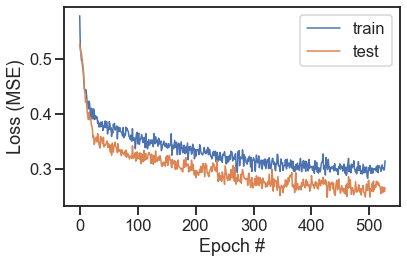

In [21]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss (MSE)")

### Evaluating model accuracy

In [22]:
pred = mdl(
    [*reactant_test.transpose(1, 0, 2), *present_test.transpose(1, 0), reagent_test]
)

pred = np.stack(pred).mean(axis=(0, 2))
delta = pred_test - pred

{
    "Mean squared error (baseline)": np.mean(delta * delta),
    "Mean absolute error (baseline)": np.mean(np.abs(delta)),
    "Mean squared error (baseline, weighted)": np.mean(weights_test * delta * delta),
    "Mean absolute error (baseline, weighted)": np.mean(weights_test * np.abs(delta)),
}

{'Mean squared error (baseline)': 0.04184484,
 'Mean absolute error (baseline)': 0.16380449,
 'Mean squared error (baseline, weighted)': 0.04097987653828008,
 'Mean absolute error (baseline, weighted)': 0.16728816836219026}

#### Comparison to baseline accuracy
As a baseline model we propose one with a constant prediction equal to the average reactivity in the training set

In [23]:
baseline_pred = pred_train.mean()

delta = pred_test - baseline_pred

{
    "Mean squared error (baseline)": np.mean(delta * delta),
    "Mean absolute error (baseline)": np.mean(np.abs(delta)),
    "Mean squared error (baseline, weighted)": np.mean(weights_test * delta * delta),
    "Mean absolute error (baseline, weighted)": np.mean(weights_test * np.abs(delta)),
}

{'Mean squared error (baseline)': 0.07958939,
 'Mean absolute error (baseline)': 0.24156313,
 'Mean squared error (baseline, weighted)': 0.11189074322693884,
 'Mean absolute error (baseline, weighted)': 0.2889966966332564}

#### Comparing to dummy model
The dummy model predicts the most common class (0: unreactive) for all observations

In [24]:
dummy_pred = np.zeros_like(pred_test)

delta = pred_test - dummy_pred

{
    "Mean squared error (baseline)": np.mean(delta * delta),
    "Mean absolute error (baseline)": np.mean(np.abs(delta)),
    "Mean squared error (baseline, weighted)": np.mean(weights_test * delta * delta),
    "Mean absolute error (baseline, weighted)": np.mean(weights_test * np.abs(delta)),
}

{'Mean squared error (baseline)': 0.22068562,
 'Mean absolute error (baseline)': 0.37645924,
 'Mean squared error (baseline, weighted)': 0.3591672072836551,
 'Mean absolute error (baseline, weighted)': 0.5402900532565874}

### Predicted–expectation correlation

In [25]:
dfs = []
outputs = [
    mdl(
        [
            *reactant_test.transpose(1, 0, 2),
            *present_test.transpose(1, 0),
            reagent_test,
        ],
        training=True,
    )
    for _ in range(10)
]
for j, output in enumerate(outputs):
    for i, o in enumerate(output):
        dfs.append(
            pd.DataFrame(
                {
                    "point": np.arange(len(o)),
                    "permutation": i,
                    "sample": j,
                    "expected": pred_test,
                    "predicted": o.numpy().flatten(),
                }
            )
        )
results = pd.concat(dfs, ignore_index=True)

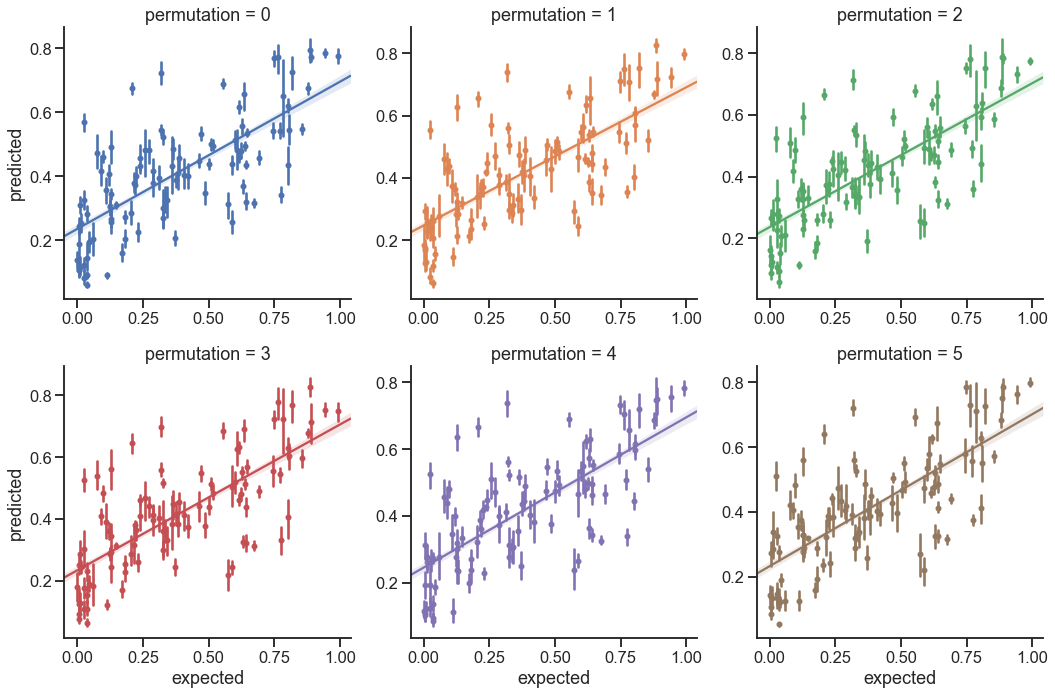

In [26]:
f = sns.lmplot(
    data=results,
    x="expected",
    y="predicted",
    col="permutation",
    hue="permutation",
    col_wrap=3,
    x_jitter=0.02,
    scatter_kws={"s": 20},
    x_estimator=np.mean,
    sharex=False,
    sharey=False,
)

f.savefig(f"Model stats - {active_space}.svg")

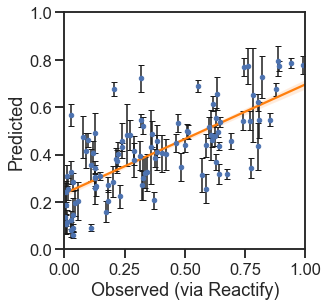

In [27]:
palette = sns.mpl_palette("tab10", 10)
perm0 = results[results.permutation == 0]
grp = perm0.groupby("point")
f, a = plt.subplots(figsize=(4.9, 4.6))

a.errorbar(
    grp.mean().expected,
    grp.mean().predicted,
    yerr=grp.std().predicted,
    fmt=".",
    ecolor="k",
    elinewidth=1.5,
    capsize=3,
)

sns.regplot(
    data=perm0,
    x="expected",
    y="predicted",
    x_jitter=0.02,
    ax=a,
    scatter=False,
    line_kws={"color": palette[1]},
)

a.set_xlim(0, 1)
a.set_ylim(0, 1)
a.set_xlabel("Observed (via Reactify)")
a.set_ylabel("Predicted")

f.savefig(f"Model stats 2 - {active_space}.svg", transparent=True, bbox_inches="tight")

In [28]:
results[results.permutation == 0]

,point,permutation,sample,expected,predicted
0,0,0,0,0.179568,0.132643
1,1,0,0,0.613760,0.458202
2,2,0,0,0.005880,0.287438
3,3,0,0,0.326243,0.274094
4,4,0,0,0.747098,0.763883
...,...,...,...,...,...
5605,97,0,9,0.058275,0.329135
5606,98,0,9,0.572912,0.375411
5607,99,0,9,0.742973,0.515639
5608,100,0,9,0.004380,0.102145


### Confusion matrix

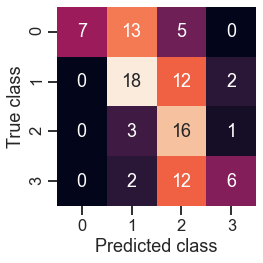

In [29]:
f, a = plt.subplots(figsize=(4, 4))
expected_classes = np.round(pred_test * 4)
out_classes = np.round(
    mdl(
        [*reactant_test.transpose(1, 0, 2), *present_test.transpose(1, 0), reagent_test]
    )[0]
    * 4
)
cm = confusion_matrix(expected_classes, out_classes, labels=range(4))
ax = sns.heatmap(cm, square=True, annot=True, ax=a, cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class");

## Error-uncertainty correlation

In [30]:
results["diff"] = (results["predicted"] - results["expected"]).abs()
results["diff2"] = results["diff"] ** 2
grp = results.groupby(["point", "permutation"])

In [31]:
correlation_df = pd.DataFrame(
    {
        "Error (mse)": grp["diff"].mean(),
        "Error (mae)": grp["diff2"].mean(),
        "Uncertainty": grp["predicted"].std(),
    },
)

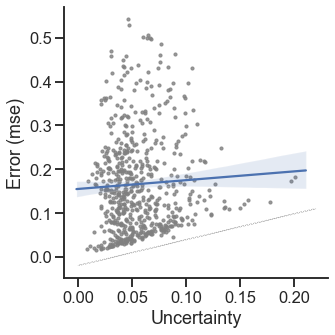

In [53]:
# c = correlation_df.loc[(slice(None), 5), :]
c = correlation_df
sns.lmplot(
    "Uncertainty", "Error (mse)", data=c, scatter_kws={"s": 10, "color": "grey"},
)

plt.arrow(0, -0.02, 0.22, 0.13, width=0.002, head_width=0.0, fc="grey", ls=":")

plt.savefig(
    "Error-uncertainty correlation.png",
    transparent=True,
    dpi=200,
    pad_inches=0.0,
    bbox_inches="tight",
)

In [54]:
error_perm = np.argsort(c["Error (mse)"])
uncertainty_perm = np.argsort(c["Uncertainty"])
cov = np.cov(np.stack([error_perm, uncertainty_perm]))

### Spearman correlation coefficient

In [55]:
cov[0, 1] / cov[0, 0]

0.05761196141095975

## Benchmarking on an imaginary chemical space

In [56]:
synthetic_reactants = {
    "cyclopenten-1-ylboronic acid": "OB(O)C1=CCCC1",
    "Indole-3-carboxaldehyde": "O=Cc1c[nH]c2ccccc12",
    "4-nitroaniline": "Nc1ccc(cc1)[N+]([O-])=O",
    "3,4-Dimethylbenzaldehyde": "Cc1ccc(C=O)cc1C",
    "5-chloro-3-(bromomethyl)-1,2,4-thiadiazole": "BrCc1nsc(Cl)n1",
    "vinyl acetate": "C=COC(C)=O",
}

synthetic_fps = fp_calculator(list(synthetic_reactants.values()))

100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


In [57]:
# binary and three-component combinations
combinations = [itertools.combinations(range(len(synthetic_fps)), n) for n in [2, 3]]
all_combinations = []
for c in combinations:
    all_combinations += list(c)

In [58]:
synthetic_reactant_fps = np.zeros(
    (len(all_combinations), 3, synthetic_fps.shape[1]), dtype="float32"
)
synthetic_reagents = np.zeros((len(all_combinations), 5), dtype="float32")
synthetic_present = np.zeros((len(all_combinations), 3), dtype="float32")

for i, comb in enumerate(all_combinations):
    comb = list(comb)
    synthetic_reactant_fps[i, : len(comb)] = synthetic_fps[comb]
    synthetic_present[i, : len(comb)] = 1.0

In [59]:
predictions_mat = np.concatenate(
    [
        mdl(
            [
                *synthetic_reactant_fps.transpose(1, 0, 2),
                *synthetic_present.transpose(1, 0),
                synthetic_reagents,
            ],
            training=True
        )
        for _ in range(100)
    ],
    axis=0,
)

In [60]:
predictions_df = pd.DataFrame(predictions_mat.squeeze())

In [63]:
predictions_df.rename(
    columns={n: "+".join(str(i) for i in comb) for n, comb in enumerate(all_combinations)},
    inplace=True,
)

In [65]:
pd.DataFrame(
    {
        "name": list(synthetic_reactants.keys()),
        "smiles": list(synthetic_reactants.values()),
    },
)

,name,smiles
0,cyclopenten-1-ylboronic acid,OB(O)C1=CCCC1
1,Indole-3-carboxaldehyde,O=Cc1c[nH]c2ccccc12
2,4-nitroaniline,Nc1ccc(cc1)[N+]([O-])=O
3,"3,4-Dimethylbenzaldehyde",Cc1ccc(C=O)cc1C
4,"5-chloro-3-(bromomethyl)-1,2,4-thiadiazole",BrCc1nsc(Cl)n1
5,vinyl acetate,C=COC(C)=O


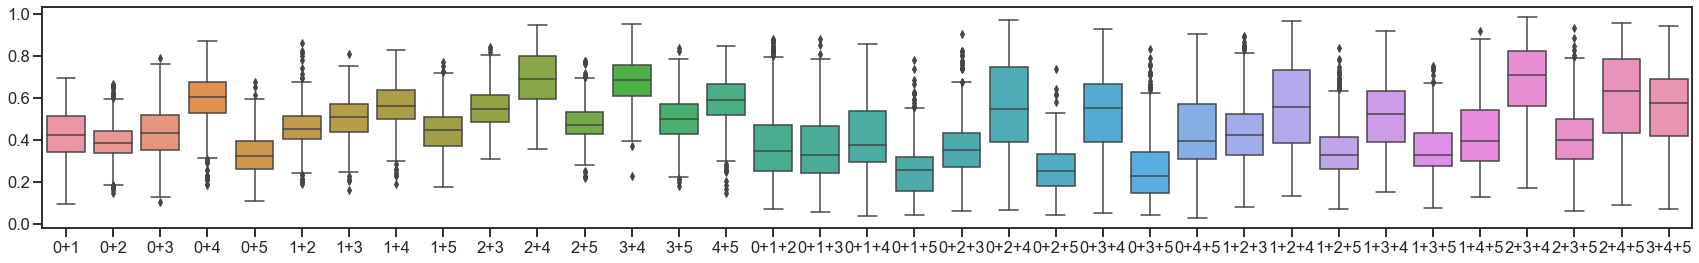

In [66]:
f, a = plt.subplots(figsize=(24, 4))
sns.boxplot(data=predictions_df, ax=a);

# Chemical space exploration

In [72]:
class Explorer:
    def __init__(self):
        pass

    def train(
        self,
        reactant_train,
        present_train,
        reagent_train,
        pred_train,
        callbacks=None,
        weights_train=None,
        fit_kwargs=None,
    ):
        self.model = nn_model(normalizer=normalizer)
        self.model.compile(optimizer="adam", loss="mse", metrics=["mae"])
        if callbacks is None:
            callbacks = [
                EarlyStopping(patience=20, verbose=0, restore_best_weights=True)
            ]
        self.model.fit(
            x=[
                *reactant_train.transpose(1, 0, 2),
                *present_train.transpose(1, 0),
                reagent_train,
            ],
            y=[pred_train] * factorial(3),
            sample_weight=weights_train,
            batch_size=8,
            validation_data=(
                [
                    *reactant_test.transpose(1, 0, 2),
                    *present_test.transpose(1, 0),
                    reagent_test,
                ],
                [pred_test] * factorial(3),
                weights_test,
            ),
            callbacks=callbacks,
            epochs=4000,
            verbose=0,
            **(fit_kwargs or {})
        )

    def test(self, reactant_test, present_test, reagent_test):
        return np.mean(
            np.concatenate(
                self.model(
                    [
                        *reactant_test.transpose(1, 0, 2),
                        *present_test.transpose(1, 0),
                        reagent_test,
                    ]
                ),
                axis=1,
            ),
            axis=1,
        )

In [73]:
class ChemicalSpace:
    """
    Class to manage the simulated chemical space. It keeps track of experiments that
    have been seen or unseen by the algorithm.
    methods:
    random_guess: assign a random percentage to the seen reactions
    update_explored_indexes: assign the selected indexes to the seen reactions
    update_df: based on seen/unseen indexes it splits the complete dataset
    accordingly
    """

    def __init__(
        self,
        reactant_fps,
        present_mat,
        reagent_mat,
        predictions,
        sample_weights,
        seed=2018,
    ):
        random.seed(seed)

        self.all_reactant_fps = reactant_fps
        self.all_present_mat = present_mat
        self.all_reagent_mat = reagent_mat
        self.all_predictions = predictions
        self.all_sample_weights = sample_weights

        self.unseen = list(range(len(self.all_reactant_fps)))
        self.seen = []
        self.space_len = len(self.unseen)

        random.shuffle(self.unseen)

    def random_guess(self, reveal_fraction: float):
        num_of_rxns = int(self.space_len * reveal_fraction)
        random_idxs = []

        for idx in self.unseen:
            self.seen.append(idx)
            random_idxs.append(idx)
            if len(random_idxs) == num_of_rxns:
                break
        for idx in random_idxs:
            self.unseen.remove(idx)

        self.update_df()

    def update_explored_indexes(self, indexes):
        for idx in indexes:
            self.seen.append(idx)
            self.unseen.remove(idx)
        self.update_df()

    def update_df(self):
        self.reactant_fps = self.all_reactant_fps[self.seen]
        self.present_mat = self.all_present_mat[self.seen]
        self.reagent_mat = self.all_reagent_mat[self.seen]
        self.predictions = self.all_predictions[self.seen]
        self.sample_weights = self.all_sample_weights[self.seen]

        self.unseen_reactant_fps = self.all_reactant_fps[self.unseen]
        self.unseen_present_mat = self.all_present_mat[self.unseen]
        self.unseen_reagent_mat = self.all_reagent_mat[self.unseen]
        self.unseen_predictions = self.all_predictions[self.unseen]
        self.unseen_sample_weights = self.all_sample_weights[self.unseen]


class Simulation:
    """
    class used for the simulated exploration of the chemical space. It trains the
    neural netowork on pregressively bigger datasets and tries to explore the space
    performing the reactive combinations first.
    """

    def __init__(
        self,
        chemical_space: ChemicalSpace,
        reveal_fraction=0.1,
        screen_size=50,
        monitor_reactions=None,
    ):
        self.chemical_space = chemical_space
        self.reveal_fraction = reveal_fraction
        self.screen_size = screen_size
        self.model = Explorer()
        self.results = []
        if monitor_reactions:
            self.monitor_reactions = {i: -1 for i in monitor_reactions}
        else:
            self.monitor_reactions = None

    def explore_space(self):
        # defines the batch size for exploration of chemical space
        screen_size = 50
        # randomly guess select 10 % of chemical space
        self.chemical_space.random_guess(self.reveal_fraction)

        # keep statistics for plotting
        rxn = [0.5 * len(self.chemical_space.seen)]
        width = [0.95 * len(self.chemical_space.seen)]
        self.results.append([i for i in self.chemical_space.predictions])

        # Evaluate average yield of selected reactions
        avg_real_yield = [np.mean(self.chemical_space.predictions)]
        # Evaluate standard deviation
        stds = [np.std(self.chemical_space.predictions)]

        iteration = 0

        while not len(self.chemical_space.unseen) == 0:
            # Add data to plot
            if iteration == 0:
                rxn.append(2 * rxn[-1] + 0.5 * screen_size)
            else:
                if len(self.chemical_space.unseen) < screen_size:
                    screen_size = len(self.chemical_space.unseen)
                rxn.append(rxn[-1] + screen_size)

            width.append(0.95 * screen_size)

            # train neural network with seen data
            print(f"Training on {len(self.chemical_space.seen)}")
            self.model.train(
                self.chemical_space.reactant_fps,
                self.chemical_space.present_mat,
                self.chemical_space.reagent_mat,
                self.chemical_space.predictions,
                weights_train=self.chemical_space.sample_weights,
            )

            # assign reactivity to unseen data
            self.yp = self.model.test(
                self.chemical_space.unseen_reactant_fps,
                self.chemical_space.unseen_present_mat,
                self.chemical_space.unseen_reagent_mat,
            )

            # Sort the dataframe by predicted yield
            unseen_df = pd.DataFrame(
                {
                    "prediction": self.yp,
                    "indexes": self.chemical_space.unseen,
                    "real_react": self.chemical_space.unseen_predictions,
                }
            ).sort_values(by=["prediction"], ascending=False)
            # Get a dataframe with best candidates from prediction
            self.best_results = unseen_df.head(self.screen_size)
            # Get idxs of best candidates
            best_results_idxs = list(self.best_results["indexes"])
            # Evaluate real reactivitity of selected batch of reactions
            avg_real_yield.append(np.mean(self.best_results["real_react"]))
            # Calcuate and print the standard deviation for current batch of reactions
            stds.append(np.std(self.best_results["real_react"]))
            self.results.append(list(self.best_results["real_react"]))
            # Add the current batch of reactions to explored reactions so in
            # the next iteration neural network can be trained on updated data
            self.chemical_space.update_explored_indexes(best_results_idxs)

            if self.monitor_reactions:
                for rxn_no in self.monitor_reactions:
                    if (
                        rxn_no in self.chemical_space.seen
                        and self.monitor_reactions[rxn_no] < 0
                    ):
                        self.monitor_reactions[rxn_no] = iteration

                # terminate search if all reactions of interest found
                for val in self.monitor_reactions.values():
                    if val < 0:
                        # not found yet; continue exploring
                        break
                else:
                    # all reactions of interest found; terminate search
                    return rxn, avg_real_yield, stds, width, self.results
            iteration += 1

        return rxn, avg_real_yield, stds, width, self.results

In [74]:
cs = ChemicalSpace(
    reactant_fps=reaction_fps,
    present_mat=present_mat,
    reagent_mat=reagent_mat,
    predictions=predictions,
    sample_weights=sample_weights,
)

In [75]:
simulation = Simulation(cs)

In [76]:
rxn, avg_real_yield, stds, width, results = simulation.explore_space()

Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
Training on 401
Training on 451
Training on 501
Training on 551
Training on 601
Training on 651
Training on 701
Training on 751
Training on 801
Training on 851
Training on 901
Training on 951
Training on 1001


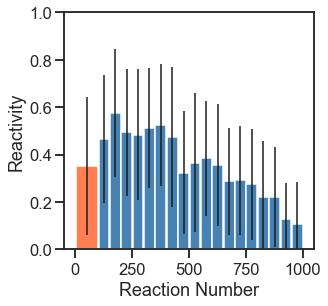

In [77]:
plt.figure(figsize=(4.9, 4.6))
colors = ["steelblue" for i in range(len(rxn))]
colors[0] = "coral"
plt.bar(
    rxn[:-1], avg_real_yield[:-1], yerr=stds[:-1], width=width[:-1], color=colors[:-1],
)
# plt.title("Average reactivity per reactions batch")
plt.xlabel("Reaction Number")
plt.ylabel("Reactivity")
plt.ylim(0, 1)
plt.savefig(
    f"Simulated exploration {active_space}.svg", transparent=True, bbox_inches="tight"
)

### Simulating the discovery of reactions of interest

In [78]:
reactions_of_interest = [
    50,  # Formation of trimer #29
    187,  # Photochemical reaction forming compound #28
]

In [79]:
data.loc[reactions_of_interest]

,bromoacetonitrile,bromomalonate,diethyl_thiobarbituric_acid,dimethyl_nitrosoaniline,dimethylisoxazole,ethyl_vinyl_ether,glycidyl_propargyl_ether,hexadienal,indole,phenylboronic_acid,...,phenylurazole,thiadiazole,tosyl_isocyanide,vinyl_pyrrolidinone,base,acid,pyrylium,rose_bengal,rubypy,prediction
50,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0.819559
187,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.877370


In [80]:
found = {i: [] for i in reactions_of_interest}

for i in range(100):
    print(f"---------------ITERATION {i}-------------------")
    print(found)
    cs = ChemicalSpace(
        reactant_fps=reaction_fps,
        present_mat=present_mat,
        reagent_mat=reagent_mat,
        predictions=predictions,
        sample_weights=sample_weights,
        seed=i,
    )
    sim = Simulation(cs, monitor_reactions=reactions_of_interest)
    rxn, avg_real_yield, stds, width, results = sim.explore_space()
    for rxn in found:
        found[rxn].append(sim.monitor_reactions[rxn])

---------------ITERATION 0-------------------
{50: [], 187: []}
Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
---------------ITERATION 1-------------------
{50: [4], 187: [5]}
Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
---------------ITERATION 2-------------------
{50: [4, 5], 187: [5, 2]}
Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
Training on 401
Training on 451
---------------ITERATION 3-------------------
{50: [4, 5, 7], 187: [5, 2, 4]}
Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
Training on 401
Training on 451
Training on 501
Training on 551
---------------ITERATION 4-------------------
{50: [4, 5, 7, 9], 187: [5, 2, 4, 1]}
Training on 101
Training on 151
Training on 201
Training on 251
Training on 301
Training on 351
Training on 401
---------------ITERATION 5------------------

Average number of iterations before reaction discovery (mean number of iterations using random search = 10)

In [81]:
{rxn: np.mean(iters) for rxn, iters in found.items()}

{50: 5.82, 187: 2.0}